In [1]:
import torch, shap

import torch
import numpy as np
import xarray as xr
from pathlib import Path
import time

import dask
import json
import geopandas as gpd

from hython.preprocess import apply_normalization
from hython.sampler import RegularIntervalSampler, DataLoaderSpatialSampler
from hython.utils import missing_location_idx, reconstruct_from_missing, load, store_as_zarr, read_from_zarr, reshape_to_2Dspatial
from hython.models.lstm import CustomLSTM

# viz
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, CenteredNorm

norm = CenteredNorm()
cmap = plt.colormaps['RdBu']

/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# choose model from model folder /mnt/CEPH_PROJECTS/InterTwin/Wflow/models
wflow_model =  "alps1km_eobs"#, adg1km_eobs
EXP = "s000100" # experiment
SEED = 1696

train_start = "2016-01-01"
train_end = "2018-12-31"

test_start = "2019-01-01"
test_end = "2020-12-31"


dynamic_names = ["precip", "pet", "temp"] #  WFLOW forcings, input features of the surrogate
static_names = [ 'thetaS', 'thetaR', 'RootingDepth', 'Swood','KsatVer', "Sl"] # WFLOW static parameters, input features of the surrogate
target_names = [ "vwc"] # WFLOW outputs, targets of the surrogate

# training parameter

SPATIAL_BATCH_SIZE = 256
TEMPORAL_SAMPLING_SIZE = 150 
SEQ_LENGTH = 360 

# model hyper parameters
HIDDEN_SIZE = 24
INPUT_SIZE = len(dynamic_names)
OUTPUT_SIZE = len(target_names)
NUMBER_STATIC_PREDICTORS = len(static_names)


TARGET_INITIALS = "".join([i[0].capitalize() for i in target_names])
train_range = slice(train_start,train_end)
test_range = slice(test_start, test_end)


# paths

wd = Path("/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_training")
input_dir_path = Path('/mnt/CEPH_PROJECTS/InterTwin/Wflow/models') / wflow_model
dp_surrogate_model = Path("/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model")
surrogate_data = wd / f"{wflow_model}.zarr"
surrogate_model = dp_surrogate_model / f"{wflow_model}_{EXP}_v{TARGET_INITIALS}_h{HIDDEN_SIZE}_seed{SEED}.pt"

In [3]:
#load data
Xd = read_from_zarr(url=surrogate_data , group="xd", multi_index="gridcell").sel(time = train_range).xd
Xs = read_from_zarr(url=surrogate_data , group="xs", multi_index="gridcell").xs
Y = read_from_zarr(url=surrogate_data , group="y", multi_index="gridcell").sel(time = train_range).y

Xd_test = read_from_zarr(url=surrogate_data, group="xd", multi_index="gridcell").sel(time = test_range).xd
Y_test = read_from_zarr(url=surrogate_data, group="y", multi_index="gridcell").sel(time = test_range).y

mask_missing = read_from_zarr(url=surrogate_data, group="mask" ).mask
#mask_lake = read_from_zarr(url=surrogate_data, group="mask_lake" ).mask_lake

#wflow_lakes = Xs.sel(feat="wflow_lakeareas").unstack()
wflow_dem = Xs.sel(feat="wflow_dem").unstack()
wflow_landuse = Xs.sel(feat="wflow_landuse").unstack()

# train 
Xd = Xd.sel(feat=dynamic_names)
Xs = Xs.sel(feat=static_names)
Y = Y.sel(feat=target_names)

# test 
Y_test = Y_test.sel(feat=target_names)
Xd_test = Xd_test.sel(feat=dynamic_names)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# instantiate the sampler, each experiment samples a different number of cells

if EXP == "s001000":    # 1 %
    print("sampling rate 1 %")
    intervals = [4, 4]
    val_origin = [2, 2]
    train_origin = [0, 0]
elif EXP == "s000100":    # 0.1 %
    print("sampling rate 0.1 %")
    intervals = [11, 11]
    val_origin = [6 ,6 ]
    train_origin = [0, 0]
elif EXP == "s000010":   # 0.01 %
    print("sampling rate 0.01 %")
    intervals = [36, 36]
    val_origin = [18, 18]
    train_origin = [0, 0]
elif EXP == "s000001":  # 0.001 %
    print("sampling rate 0.001 %")
    intervals = [108, 108]
    val_origin = [64, 64]
    train_origin = [0, 0]
    
spatial_train_sampler = RegularIntervalSampler(intervals = intervals, origin = train_origin)
spatial_val_sampler = RegularIntervalSampler(intervals = intervals, origin = val_origin) 

# Apply the samplers: return the cell indices that can be used later in training and validation to sample the whole spatial domain.
data2d  = wflow_dem.values

sampler_train_meta = spatial_train_sampler.sampling_idx(data2d, mask_missing)
sampler_val_meta = spatial_val_sampler.sampling_idx(data2d, mask_missing)

# some useful metadata
print(sampler_train_meta)

sampling rate 0.1 %
SamplerResult(
 - id_grid_2d: (689, 1177) 
 - idx_sampled_1d: (6741,) 
 - idx_sampled_1d_nomissing: (3130,)) 
 - idx_missing_1d: (431441,) 
 - sampled_grid_dims: (63, 107) 
 - xr_coords: None


In [6]:
# Normalization
_, d_m, d_std = apply_normalization(Xd[sampler_train_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard')
_, s_m, s_std = apply_normalization(Xs[sampler_train_meta.idx_sampled_1d_nomissing], type = "space", how ='standard')
_, y_m, y_std = apply_normalization(Y[sampler_train_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard')

d_m,d_std = d_m.compute(), d_std.compute()
s_m, s_std = s_m.compute(), s_std.compute()
y_m, Y_std = y_m.compute() ,y_std.compute()

# use statistics from training to normalize test set (Xs static does not need to be split)
Xs = apply_normalization(Xs, type="space", how="standard",  m1 = s_m, m2 = s_std).compute().values
Xd_test = apply_normalization(Xd_test, type="spacetime", how="standard", m1 = d_m, m2 = d_std).compute().values
Y_test = apply_normalization(Y_test, type="spacetime",how="standard", m1 = y_m, m2 = y_std).compute().values

In [7]:
model = CustomLSTM(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, NUMBER_STATIC_PREDICTORS)
model = model.to(device)
model

CustomLSTM(
  (fc0): Linear(in_features=9, out_features=24, bias=True)
  (lstm): LSTM(24, 24, batch_first=True)
  (fc1): Linear(in_features=24, out_features=1, bias=True)
)

In [8]:
model.load_state_dict(torch.load(surrogate_model))

<All keys matched successfully>

In [9]:
Xs = torch.Tensor(Xs).to(device)
Xd_test = torch.Tensor(Xd_test).to(device)

In [10]:
Xd.shape, Xs.shape, device

((810953, 1096, 3), torch.Size([810953, 6]), device(type='cuda', index=0))

In [11]:
model = model.train()
torch.backends.cudnn.enabled=False

In [12]:
#remove missing values before running shap
missing_idx = missing_location_idx(Xs.cpu().numpy())

Xd_test = Xd_test[~missing_idx]

Xs = Xs[~missing_idx]

In [13]:
Xd_test.shape, Xs.shape

(torch.Size([379512, 731, 3]), torch.Size([379512, 6]))

In [ ]:
# choose rainy / no rainy day
time_idx_norain = 100 # evento no rain
time_idx_rain = 498 # evento pioggia

In [57]:
Xd.isel(time=time_idx_rain)

<xarray.DataArray 'xd' (gridcell: 810953, feat: 3)>
[2432859 values with dtype=float32]
Coordinates:
  * feat         (feat) object 'precip' 'pet' 'temp'
    spatial_ref  int64 0
    time         datetime64[ns] 2017-05-13
  * gridcell     (gridcell) object MultiIndex
  * lat          (gridcell) float64 50.03 50.03 50.03 ... 43.72 43.72 43.72
  * lon          (gridcell) float64 5.079 5.088 5.098 ... 15.84 15.85 15.86
Attributes:
    cell_methods:   time: mean
    long_name:      rainfall
    precip_fn:      eobs
    standard_name:  thickness_of_rainfall_amount
    unit:           mm
    units:          mm

## RAINY DAY

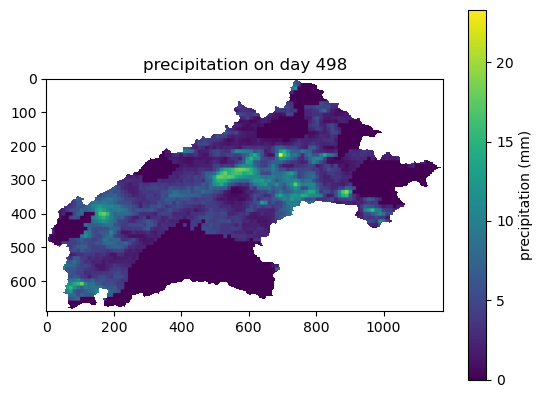

In [15]:
plt.imshow(Xd.isel(time=time_idx_rain).values.reshape(*sampler_train_meta.idx_grid_2d.shape, 3)[...,0])
plt.title(f"precipitation on day {time_idx_rain}")
plt.colorbar(label = "precipitation (mm)")

In [16]:
import random

In [17]:
base_idx = random.choices(range(Xd.shape[0]), k =100)

In [18]:
Xd_test.shape, Xs.shape

(torch.Size([379512, 731, 3]), torch.Size([379512, 6]))

In [19]:
s = Xs.unsqueeze(1).repeat(1, Xd_test.size(1), 1)

x_ds = torch.cat(
     (Xd_test,
      s),
      dim=-1,
 )

In [20]:
x_ds.shape, x_ds[:,time_idx_rain:time_idx_rain+1].squeeze(1).shape

(torch.Size([379512, 731, 9]), torch.Size([379512, 9]))

In [ ]:
explainer = shap.GradientExplainer(model, data = x_ds[:,time_idx_rain:time_idx_rain+1].squeeze(1), batch_size=516)

start = time.time()
shap_values = explainer.shap_values(x_ds[:,time_idx_rain:time_idx_rain+1].squeeze(1), nsamples=1)
end = time.time()
print((end - start) / 60,  " (minutes)")

shap_all = reconstruct_from_missing(shap_values[:, :, 0], (Xd.shape[0], Xs.shape[1] + Xd.shape[-1]), missing_idx)

### Effects of static parameters on soil moisture (shap values)

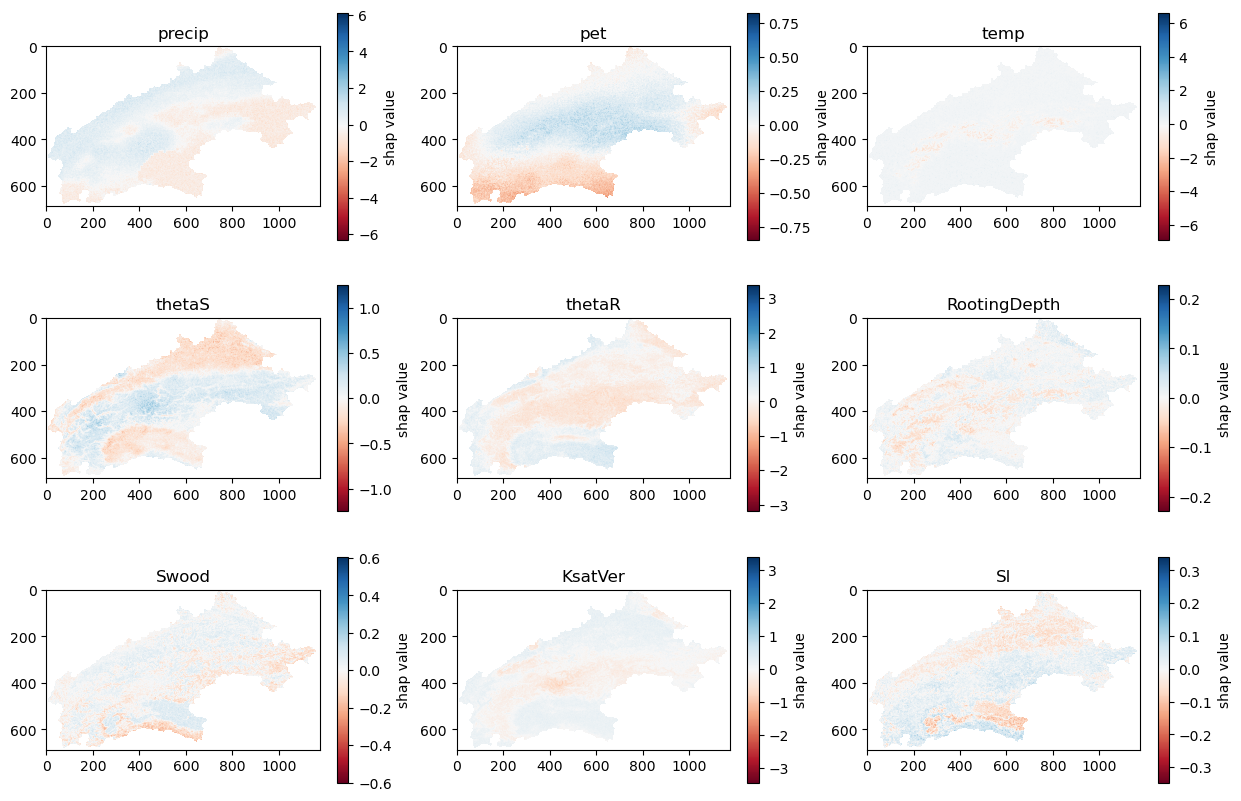

In [29]:
lat, lon = sampler_train_meta.idx_grid_2d.shape
fig, axs = plt.subplots(3,3, figsize=(15,10))
axs = axs.flatten()
shape_all_plot = shap_all.reshape(lat, lon, 9)

for i, s in enumerate(dynamic_names + static_names):
    p1 = axs[i].imshow(shape_all_plot[..., i], cmap=cmap)#, norm=norm)
    axs[i].set_title(s)
    plt.colorbar(p1, label="shap value")

In [ ]:
test = shap_values[...,-1]#shap_static[:,:,0]
test.shape

test = shap.Explanation(values=test)
test

test.data =  x_ds[:,0,:].squeeze(1).cpu().numpy()#  (shap_static[:,:,0]*s_std) + s_m

test.feature_names = dynamic_names + static_names

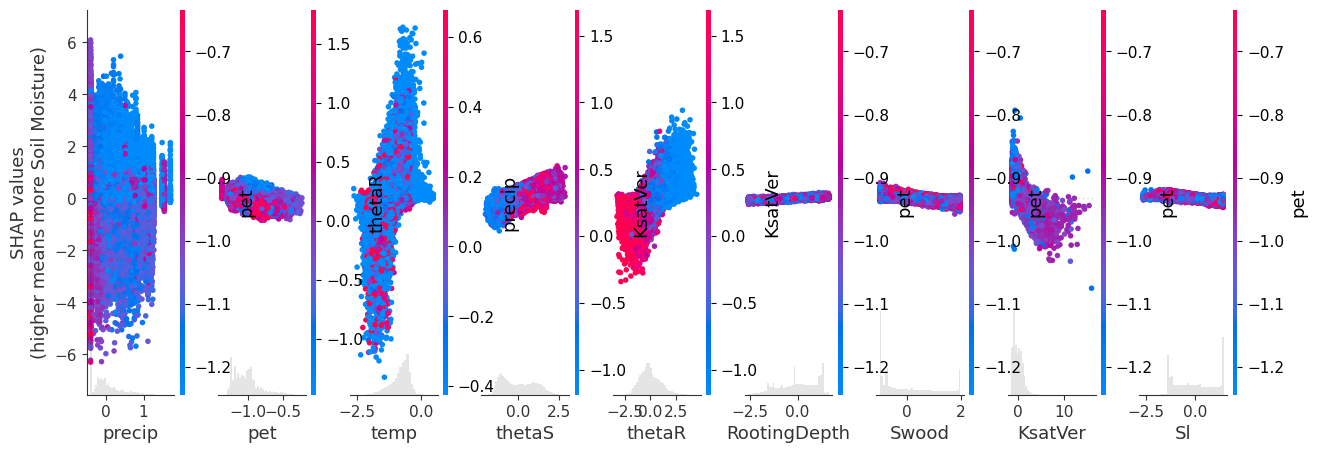

In [42]:
plt.subplots(1,1, figsize=(20,8))
shap.plots.scatter(
test, ylabel="SHAP values\n(higher means more Soil Moisture)",alpha=0.5, dot_size=2,color=test 
)

In [40]:
clustering = shap.utils.hclust(shap_values[...,-1], Y_test[~missing_idx,0,:])

10it [00:24,  4.11s/it]                                                                                                              


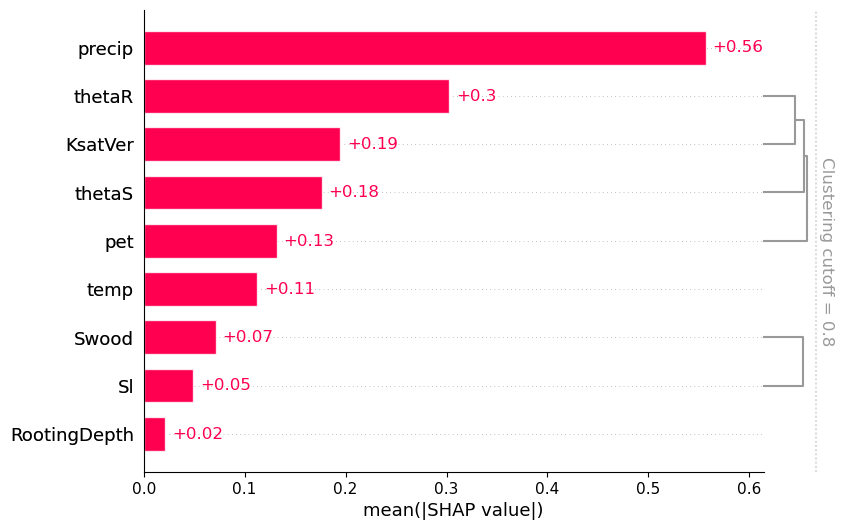

In [41]:
shap.plots.bar(test, clustering=clustering, clustering_cutoff=0.8)

## NON RAINY DAY

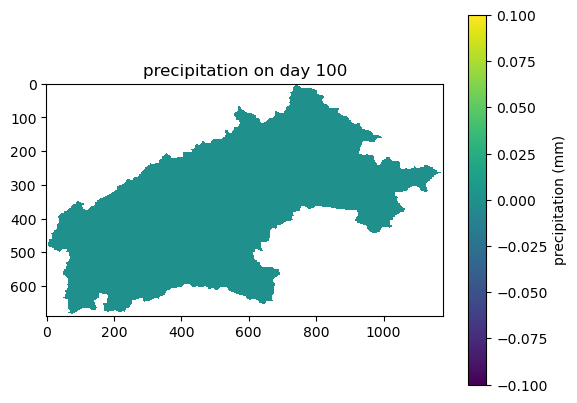

In [43]:
plt.imshow(Xd.isel(time=time_idx_norain).values.reshape(*sampler_train_meta.idx_grid_2d.shape, 3)[...,0])
plt.title(f"precipitation on day {time_idx_norain}")
plt.colorbar(label = "precipitation (mm)")

In [44]:
explainer = shap.GradientExplainer(model, data = x_ds[:,time_idx_norain:time_idx_norain+1].squeeze(1), batch_size=516)

start = time.time()
shap_values = explainer.shap_values(x_ds[:,time_idx_norain:time_idx_norain+1].squeeze(1), nsamples=1)
end = time.time()
print((end - start) / 60,  " (minutes)")

shap_all = reconstruct_from_missing(shap_values[:, :, 0], (Xd.shape[0], Xs.shape[1] + Xd.shape[-1]), missing_idx)

6.9959031025568645  (minutes)
(431441, 9)


### Effects of static parameters on soil moisture (shap values)

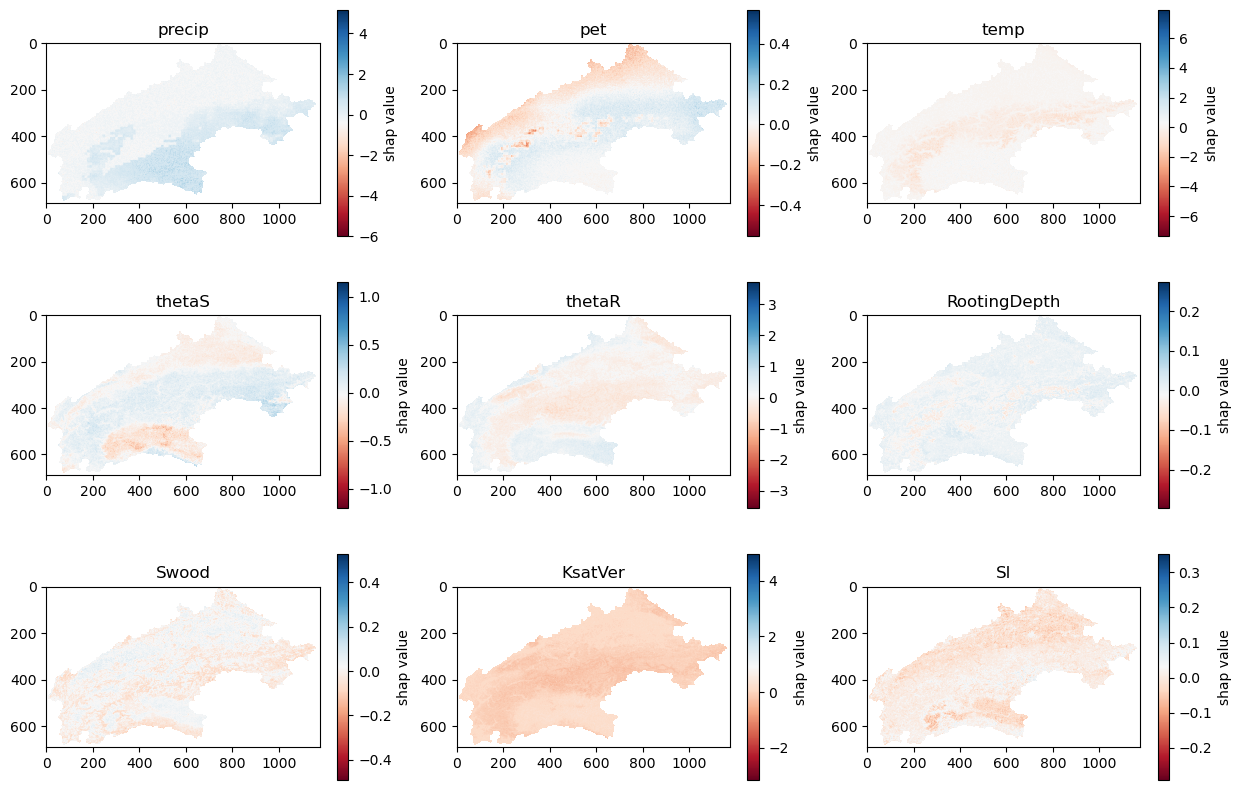

In [46]:
lat, lon = sampler_train_meta.idx_grid_2d.shape
fig, axs = plt.subplots(3,3, figsize=(15,10))
axs = axs.flatten()
shape_all_plot = shap_all.reshape(lat, lon, 9)

for i, s in enumerate(dynamic_names + static_names):
    p1 = axs[i].imshow(shape_all_plot[..., i], cmap=cmap)#, norm=norm)
    axs[i].set_title(s)
    plt.colorbar(p1, label="shap value")

In [47]:
test = shap_values[...,-1]#shap_static[:,:,0]
test.shape

test = shap.Explanation(values=test)
test

test.data =  x_ds[:,0,:].squeeze(1).cpu().numpy()#  (shap_static[:,:,0]*s_std) + s_m

test.feature_names = dynamic_names + static_names

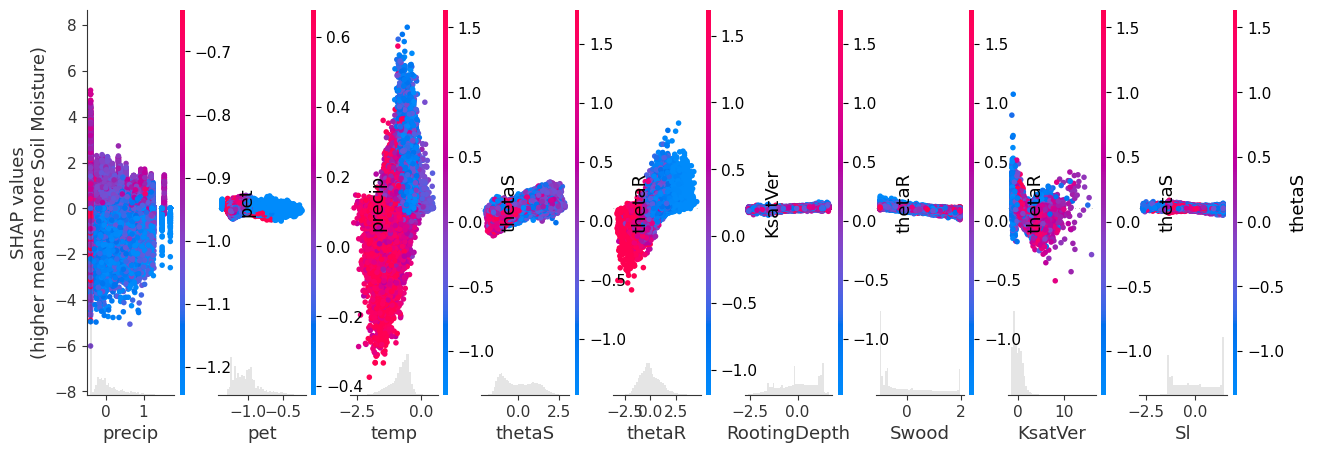

In [56]:

shap.plots.scatter(
test, ylabel="SHAP values\n(higher means more Soil Moisture)",alpha=0.5, dot_size=2,color=test)

In [49]:
clustering = shap.utils.hclust(shap_values[...,-1], Y_test[~missing_idx,0,:])

10it [00:24,  4.89s/it]                                                                                                              


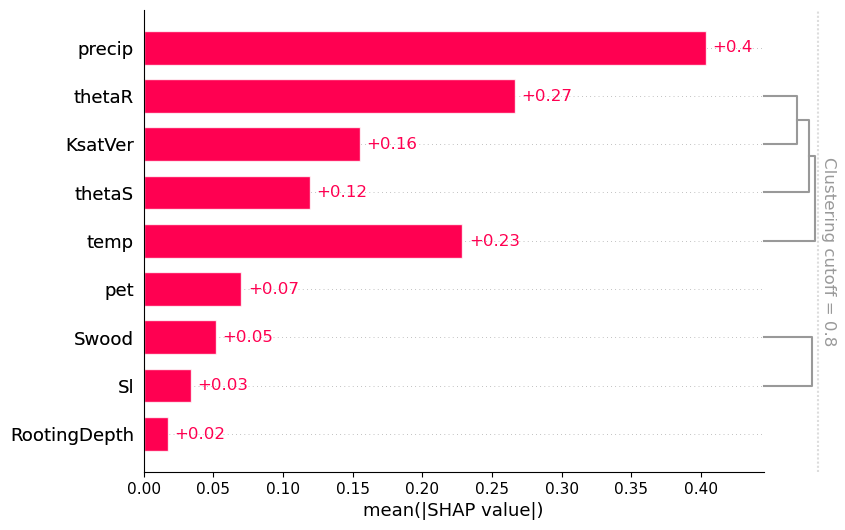

In [50]:
shap.plots.bar(test, clustering=clustering, clustering_cutoff=0.8)